<a href="https://colab.research.google.com/github/dgalassi99/quant-trading-self-study/blob/main/01_foundations/W2_Moving_Average_Strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Creating a MAs Crossing Strategy

We select different securities from stocks, to crypto and commodities

## Getting Packages and Data

In [8]:
#importing main libraries
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random

In [9]:
#let's download data for the desired securities
tickers = ['GOOGL', 'NVDA', 'XOM', 'QQQ', 'VTI', 'ETH-USD', 'GLD', 'USO', 'EURUSD=X']
start_date = '2020-01-01'
end_date = '2025-01-01'
#create a dictionary where key = ticker name and value is ticker data for each tick in tickers
data = {}
for tik in tickers:
  data[tik] = yf.download(tik, start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


## Long only startegy on one ticker

In [ ]:
#fast checking if there are missing values
for tik in tickers:
  print(data[tik].isna().sum())

Price   Ticker
Close   GOOGL     0
High    GOOGL     0
Low     GOOGL     0
Open    GOOGL     0
Volume  GOOGL     0
dtype: int64
Price   Ticker
Close   NVDA      0
High    NVDA      0
Low     NVDA      0
Open    NVDA      0
Volume  NVDA      0
dtype: int64
Price   Ticker
Close   QQQ       0
High    QQQ       0
Low     QQQ       0
Open    QQQ       0
Volume  QQQ       0
dtype: int64
Price   Ticker
Close   VTI       0
High    VTI       0
Low     VTI       0
Open    VTI       0
Volume  VTI       0
dtype: int64
Price   Ticker 
Close   ETH-USD    0
High    ETH-USD    0
Low     ETH-USD    0
Open    ETH-USD    0
Volume  ETH-USD    0
dtype: int64
Price   Ticker
Close   GLD       0
High    GLD       0
Low     GLD       0
Open    GLD       0
Volume  GLD       0
dtype: int64
Price   Ticker
Close   USO       0
High    USO       0
Low     USO       0
Open    USO       0
Volume  USO       0
dtype: int64


In [ ]:
#now we will select just a ticker here but you can change it to see how
#this simple strategy applies to different commodities
tik = 'ETH-USD'
#we will just keep close and volume as we assume the strategy is not on the short time frame
#hence we will not 'trade intraday
df = data[tik][['Close', 'Volume']]
#dropping the outer level of the columns to avoid having a multiindex dataset
df = df.droplevel(level=1, axis=1)

In [ ]:
#calculate 50,200 period MAs
df['ma20'] = df['Close'].rolling(20).mean()
df['ma50'] = df['Close'].rolling(50).mean()
#dropping the NaN rows created by the rolling function
df = df.dropna()

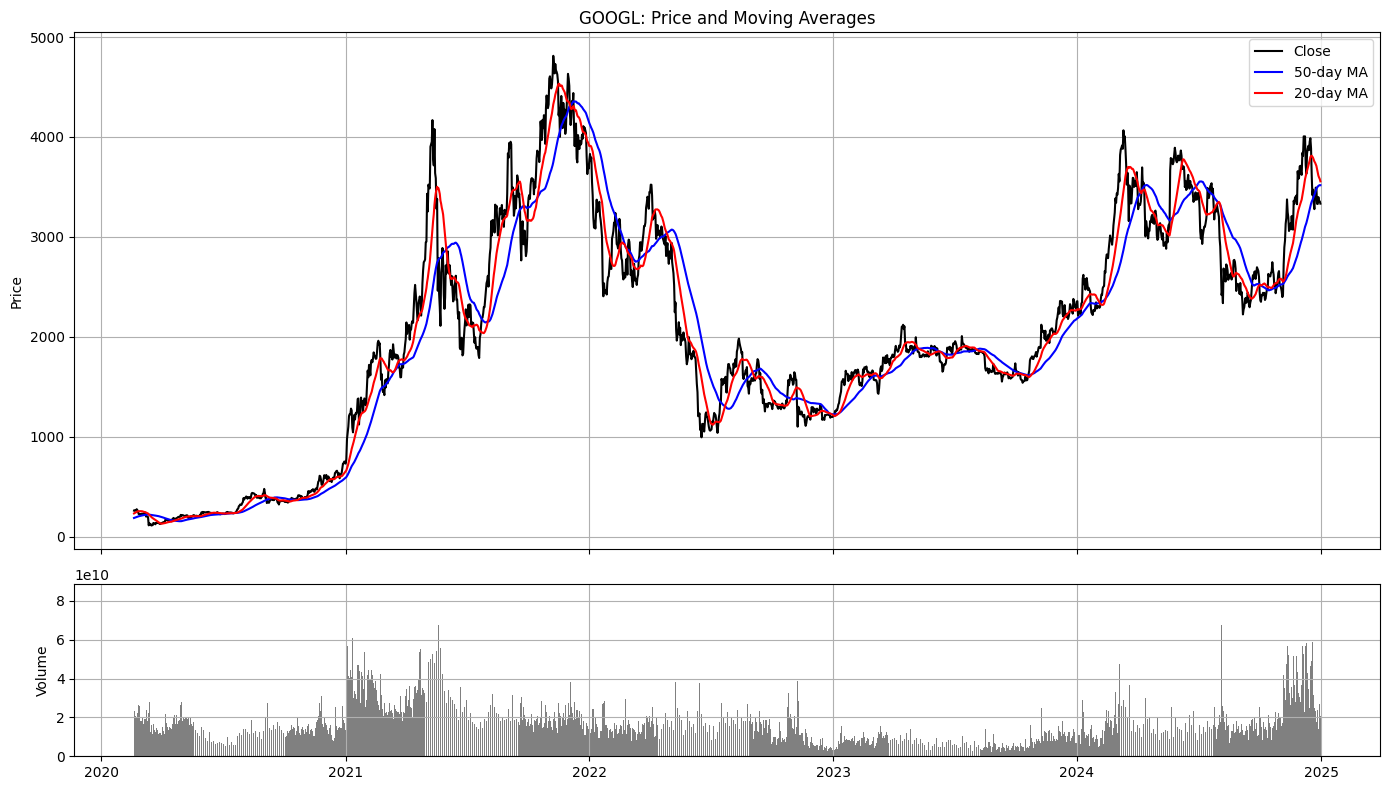

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8),
    gridspec_kw={'height_ratios': [3, 1]},sharex=True)
# --- Main price chart
ax1.plot(df['Close'], label='Close', color='black')
ax1.plot(df['ma50'], label='50-day MA', color='blue')
ax1.plot(df['ma20'], label='20-day MA', color='red')
ax1.set_title('GOOGL: Price and Moving Averages')
ax1.set_ylabel('Price')
ax1.legend()
ax1.grid(True)
# --- Volume chart
ax2.bar(df.index, df['Volume'], color='gray')
ax2.set_ylabel('Volume')
ax2.grid(True)
# --- adjusting the plot
plt.tight_layout()
plt.show()

In [ ]:
#first trading simple strategy

#long when the short frame MA breaks the long frame one
#short when the break occurs in the opposite direction

#create a column such that 1 if ma20 > ma50, 0 otherwise
df['position'] = (df['ma20'] > df['ma50']).astype(int)
#get crossover signals by checking when the position changes
df['crossover_signal'] = df['position'].diff()
#drop NaNs from diff (first row will be NaN)
df = df.dropna(subset=['crossover_signal'])

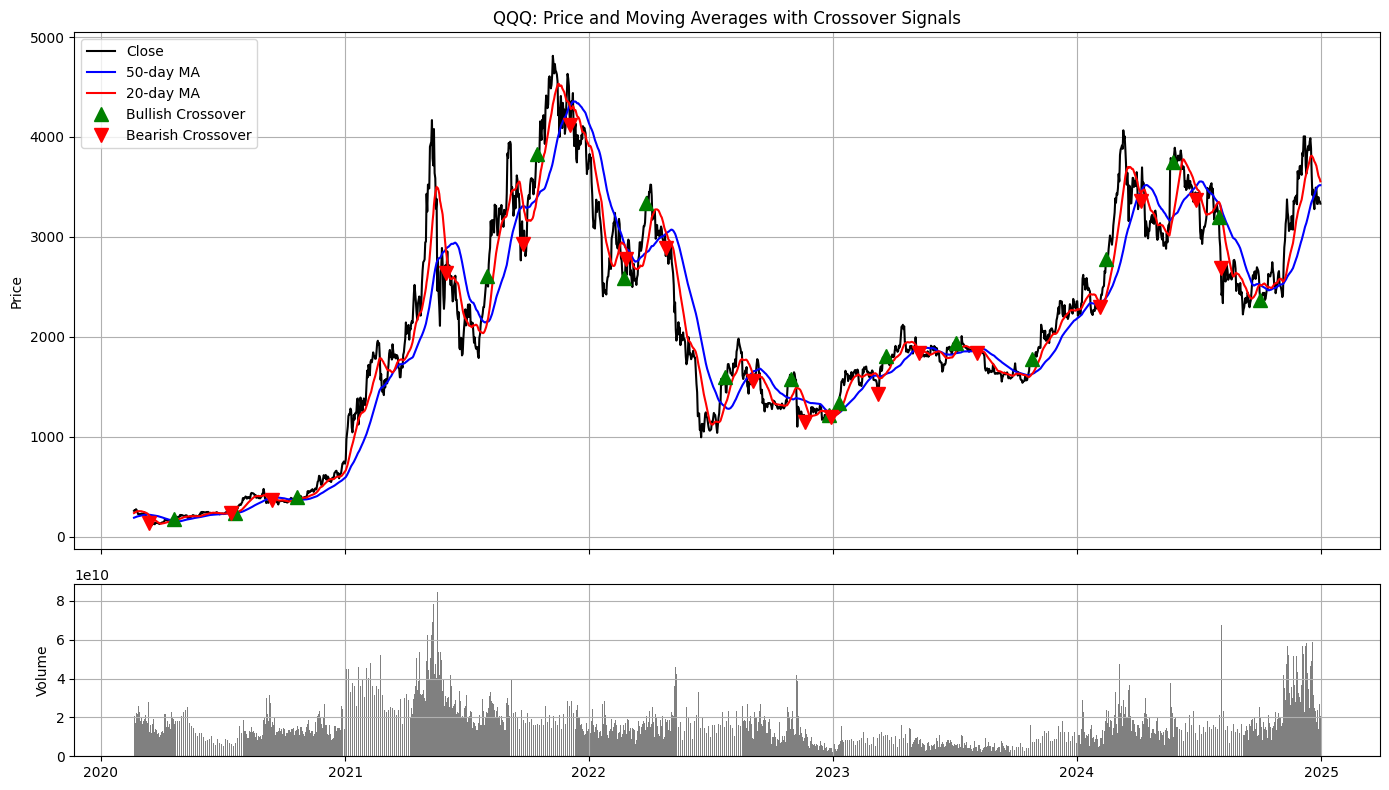

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8),
    gridspec_kw={'height_ratios': [3, 1]}, sharex=True)

# --- Main price chart
ax1.plot(df['Close'], label='Close', color='black')
ax1.plot(df['ma50'], label='50-day MA', color='blue')
ax1.plot(df['ma20'], label='20-day MA', color='red')

#add crossover signals to price chart
#bullish
bullish = df[df['crossover_signal'] == 1]
ax1.plot(bullish.index, df.loc[bullish.index, 'Close'],
         '^', markersize=10, color='green', label='Bullish Crossover')

#bearish
bearish = df[df['crossover_signal'] == -1]
ax1.plot(bearish.index, df.loc[bearish.index, 'Close'],
         'v', markersize=10, color='red', label='Bearish Crossover')

ax1.set_title('QQQ: Price and Moving Averages with Crossover Signals')
ax1.set_ylabel('Price')
ax1.legend()
ax1.grid(True)

# --- Volume chart
ax2.bar(df.index, df['Volume'], color='gray')
ax2.set_ylabel('Volume')
ax2.grid(True)

# --- Adjust layout
plt.tight_layout()
plt.show()


In [ ]:
#let's implement the first strategy:
#1. unidirectional (long-only)
#2. enter on a positive cross-over (bullish signal) and exit on a negative one (bearish signal)
#3. calcualte returns and compare with a buy&hold

#daily returns
df['daily_return'] = df['Close'].pct_change()
#strategy returns only active when in position
df['strategy_return'] = df['daily_return'] * df['position']

#cumulative returns for buy & hold adn crossover strategy
df['cumulative_buy_hold'] = (1 + df['daily_return']).cumprod()
df['cumulative_strategy'] = (1 + df['strategy_return']).cumprod()

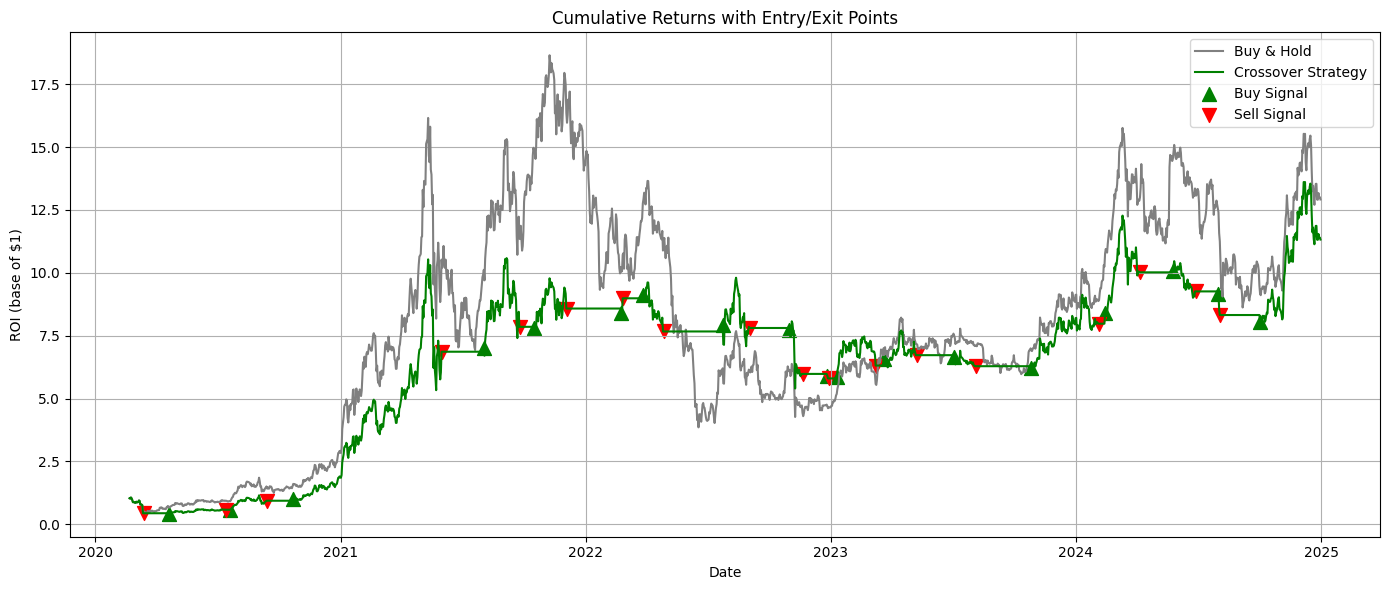

In [ ]:
plt.figure(figsize=(14,6))
#cumulative returns
plt.plot(df.index, df['cumulative_buy_hold'], label='Buy & Hold', color='gray')
plt.plot(df.index, df['cumulative_strategy'], label='Crossover Strategy', color='green')
#mark bullish crossovers (entry signals)
entry_points = df[df['crossover_signal'] == 1]
plt.scatter(entry_points.index, df.loc[entry_points.index, 'cumulative_strategy'],
            marker='^', color='green', label='Buy Signal', s=100)
#mark bearish crossovers (exit signals)
exit_points = df[df['crossover_signal'] == -1]
plt.scatter(exit_points.index, df.loc[exit_points.index, 'cumulative_strategy'],
            marker='v', color='red', label='Sell Signal', s=100)
plt.title('Cumulative Returns with Entry/Exit Points')
plt.xlabel('Date')
plt.ylabel('ROI (base of $1)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


As you can notice the buy&hold strategy looks much better. But we need to consider we are analyzing a past-performance chart and the 5 years analyzed are very bullish. In order to study something more informative I will run more simulations on the same chart where I randomized the starting date so that we remove this bias.

In [ ]:
import random
results = []

# List of valid start indices (skip first 100 for stable MA)
valid_indices = df.index[100:-100]


for _ in range(10000):
    #pick random start and ending period and slice teh dataset in this timeframe
    random_start, random_end = sorted(random.sample(list(valid_indices), 2))
    df_slice = df.loc[random_start:random_end].copy()
    #recalculate the MAs to avoid lookahead bias
    df_slice['ma20'] = df_slice['Close'].rolling(window=20).mean()
    df_slice['ma50'] = df_slice['Close'].rolling(window=50).mean()

    #define the singals: 1 for bullish crossover, -1 for bearish, 0 otherwise
    df_slice['position'] = 0
    df_slice.loc[df_slice['ma20'] > df_slice['ma50'], 'position'] = 1

    #counting how many operations have been done
    df_slice['position_change'] = df_slice['position'].diff().ne(0).astype(int)  # Count position changes
    num_operations = df_slice['position_change'].sum()

    #daily returns, strategy returns and cumulative returns
    df_slice['daily_return'] = df_slice['Close'].pct_change()
    df_slice['strategy_return'] = df_slice['daily_return'] * df_slice['position']
    df_slice['cumulative_buy_hold'] = (1 + df_slice['daily_return']).cumprod()
    df_slice['cumulative_strategy'] = (1 + df_slice['strategy_return']).cumprod()
    #store results
    final_bh = df_slice['cumulative_buy_hold'].iloc[-1]
    final_strat = df_slice['cumulative_strategy'].iloc[-1]
    entry_price = df_slice['Close'].iloc[0]
    exit_price = df_slice['Close'].iloc[-1]
    results.append((final_bh, final_strat,random_start,random_end,entry_price,exit_price,num_operations))


In [ ]:
results = pd.DataFrame(results, columns=['Buy & Hold', 'Crossover Strategy','Start','End','Entry Price','Exit Price','Operativity'])
results['Trading Days'] = results['End'] - results['Start']
#results[['Buy & Hold', 'Crossover Strategy','Trading Days']].describe()
sharpe_crossover = results['Crossover Strategy'].mean() / results['Crossover Strategy'].std()
sharpe_bnh = results['Buy & Hold'].mean() / results['Buy & Hold'].std()
sharpe_compare= (results['Crossover Strategy'].mean()-results['Buy & Hold'].mean()) / results['Buy & Hold'].std()
print(f'Sharpe Ratio Crossover: {sharpe_crossover}')
print(f'Sharpe Ratio Buy & Hold: {sharpe_bnh}')
print(f'Sharpe Ratio Compare: {sharpe_compare}')


Sharpe Ratio Crossover: 0.8729515540157171
Sharpe Ratio Buy & Hold: 0.8521173571712519
Sharpe Ratio Compare: -0.05153470367239345


In [ ]:
results[['Buy & Hold', 'Crossover Strategy','Entry Price','Exit Price','Operativity']].describe().round(4)

,Buy & Hold,Crossover Strategy,Entry Price,Exit Price,Operativity
count,10000.0000,10000.0000,10000.0000,10000.0000,10000.0000
mean,2.4633,2.3143,1843.3151,2309.4294,11.8027
std,2.8908,2.6511,1170.9013,859.2748,8.3299
min,0.2136,0.5711,222.9598,225.3871,1.0000
25%,0.8444,0.9393,659.2979,1647.8381,4.0000
50%,1.2939,1.1376,1772.7856,2084.4131,10.0000
75%,2.5659,1.7826,2682.8540,3014.6482,18.0000
max,20.0956,17.9238,4812.0874,4812.0874,33.0000


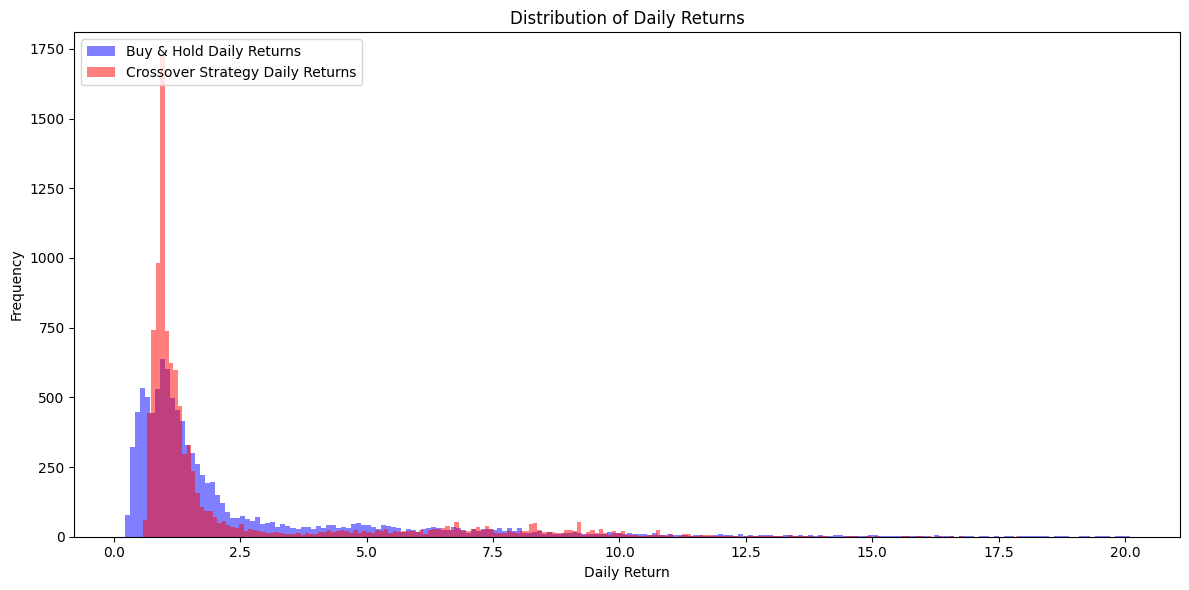

In [ ]:
#distributions of daily returns
plt.figure(figsize=(12, 6))
plt.hist(results['Buy & Hold'].dropna(), bins=200, alpha=0.5, label="Buy & Hold Daily Returns", color='blue')
plt.hist(results['Crossover Strategy'].dropna(), bins=200, alpha=0.5, label="Crossover Strategy Daily Returns", color='red')
plt.title('Distribution of Daily Returns')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


## Long only strategy on more tickers simultaneously

In [10]:
#let's now repeat for more tickers to have more distributions all togheter and compare it on different securities
#create a dictionary where key = ticker name and value is ticker data for each tick in tickers

data = {}
for tik in tickers:
  data[tik] = yf.download(tik, start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [27]:
results_dict = {}  #store results for each DataFrame

#change this number to run more simulations, up to 1000 simultations runs in short time (max 1-2 mins)
num_simulations = 500

#iterate over each DataFrame in the 'data' dictionary
for key, df in data.items():
    results = []
    valid_indices = df.index[100:-100]
    #run the simulation for the current DataFrame
    for _ in range(num_simulations):
        random_start, random_end = sorted(random.sample(list(valid_indices), 2))
        df_slice = df.loc[random_start:random_end].copy()
        df_slice['ma20'] = df_slice['Close'].rolling(window=20).mean()
        df_slice['ma50'] = df_slice['Close'].rolling(window=50).mean()
        df_slice['position'] = 0
        df_slice.loc[df_slice['ma20'] > df_slice['ma50'], 'position'] = 1
        df_slice['position_change'] = df_slice['position'].diff().ne(0).astype(int)
        num_operations = df_slice['position_change'].sum()
        df_slice['daily_return'] = df_slice['Close'].pct_change()
        df_slice['strategy_return'] = df_slice['daily_return'] * df_slice['position']
        df_slice['cumulative_buy_hold'] = (1 + df_slice['daily_return']).cumprod()
        df_slice['cumulative_strategy'] = (1 + df_slice['strategy_return']).cumprod()
        final_bh = df_slice['cumulative_buy_hold'].iloc[-1]
        final_strat = df_slice['cumulative_strategy'].iloc[-1]
        entry_price = df_slice['Close'].iloc[0]
        exit_price = df_slice['Close'].iloc[-1]
        results.append((final_bh, final_strat, random_start, random_end, entry_price, exit_price, num_operations))

#store the results for the current DataFrame in the 'results_dict'
    results_dict[key] = results


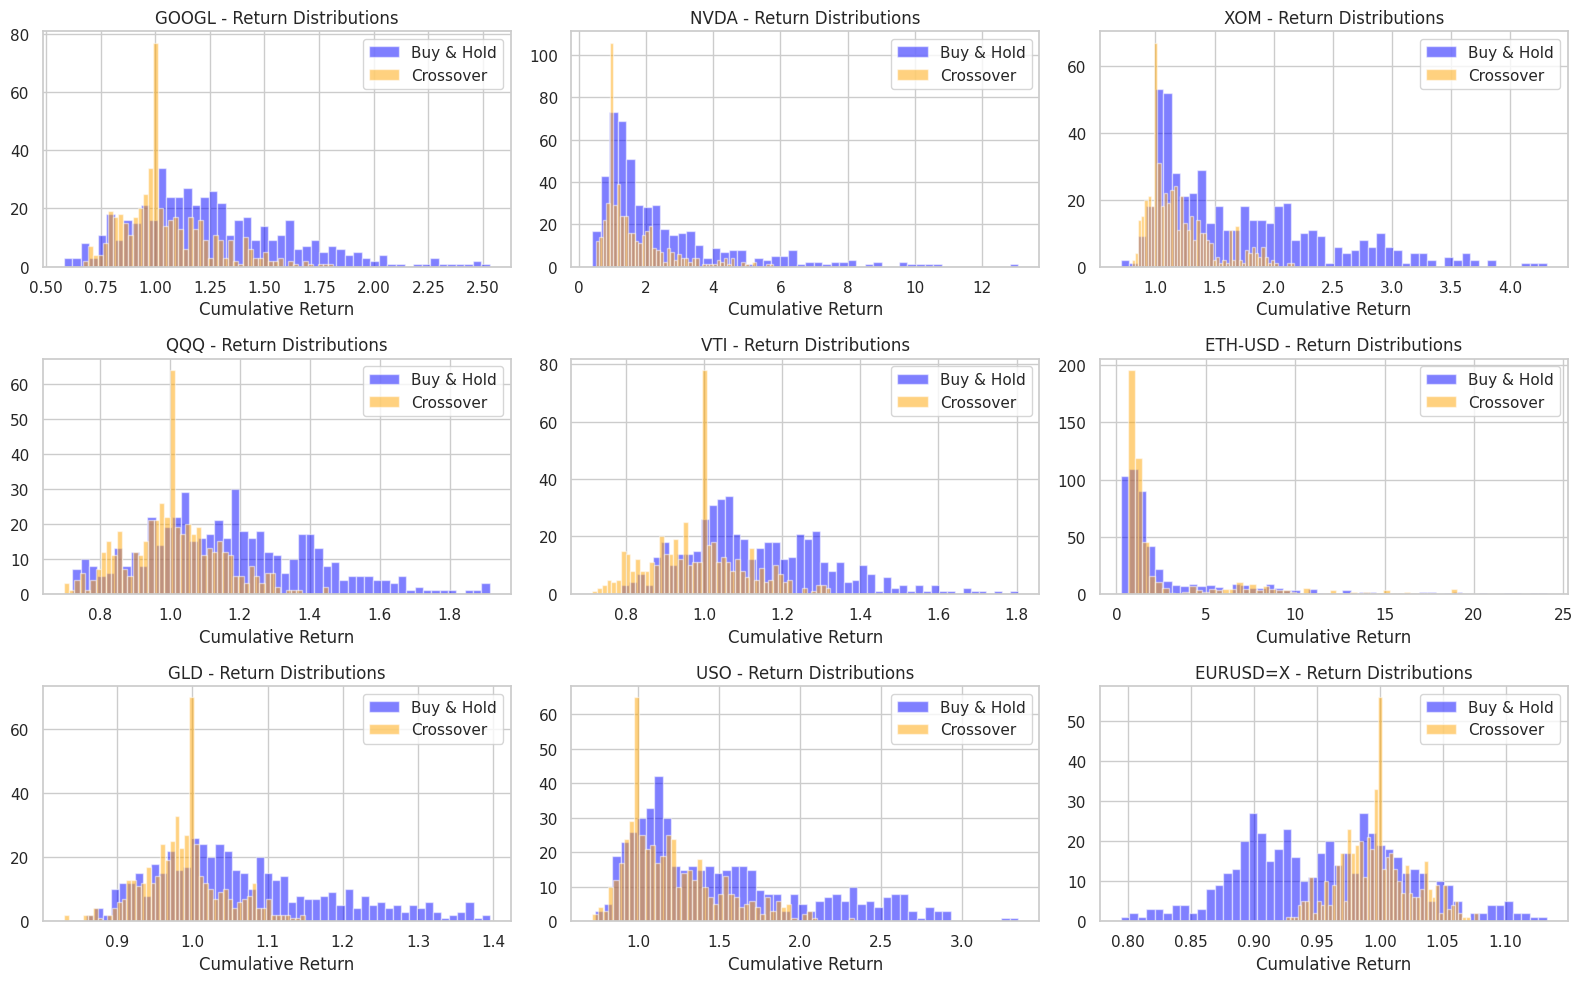

In [12]:
#plotting the distributions of returns for all the tickers selected at the beginning
sns.set(style="whitegrid")

num_keys = len(results_dict)
rows = int(np.ceil(num_keys ** 0.5))
cols = int(np.ceil(num_keys / rows))
fig, axes = plt.subplots(rows, cols, figsize=(16, 10))
axes = axes.flatten()
#loop over each key and plot distributions
for i, (key, results) in enumerate(results_dict.items()):
    df_results = pd.DataFrame(results, columns=['Buy & Hold', 'Crossover Strategy','Start', 'End', 'Entry Price', 'Exit Price', 'Operativity'])
    ax = axes[i]
    ax.hist(df_results['Buy & Hold'], bins=50, alpha=0.5, label='Buy & Hold', color='blue')
    ax.hist(df_results['Crossover Strategy'], bins=50, alpha=0.5, label='Crossover', color='orange')
    ax.set_title(f'{key} - Return Distributions')
    ax.legend()
    ax.set_xlabel('Cumulative Return')
plt.tight_layout()
plt.show()

Repeating with MA 20/100

In [15]:
results_dict = {}  #store results for each DataFrame

#change this number to run more simulations, up to 1000 simultations runs in short time (max 1-2 mins)
num_simulations = 500

#iterate over each DataFrame in the 'data' dictionary
for key, df in data.items():
    results = []
    valid_indices = df.index[100:-100]
    #run the simulation for the current DataFrame
    for _ in range(num_simulations):
        random_start, random_end = sorted(random.sample(list(valid_indices), 2))
        df_slice = df.loc[random_start:random_end].copy()
        df_slice['ma20'] = df_slice['Close'].rolling(window=20).mean()
        df_slice['ma100'] = df_slice['Close'].rolling(window=100).mean()
        df_slice['position'] = 0
        df_slice.loc[df_slice['ma20'] > df_slice['ma100'], 'position'] = 1
        df_slice['position_change'] = df_slice['position'].diff().ne(0).astype(int)
        num_operations = df_slice['position_change'].sum()
        df_slice['daily_return'] = df_slice['Close'].pct_change()
        df_slice['strategy_return'] = df_slice['daily_return'] * df_slice['position']
        df_slice['cumulative_buy_hold'] = (1 + df_slice['daily_return']).cumprod()
        df_slice['cumulative_strategy'] = (1 + df_slice['strategy_return']).cumprod()
        final_bh = df_slice['cumulative_buy_hold'].iloc[-1]
        final_strat = df_slice['cumulative_strategy'].iloc[-1]
        entry_price = df_slice['Close'].iloc[0]
        exit_price = df_slice['Close'].iloc[-1]
        results.append((final_bh, final_strat, random_start, random_end, entry_price, exit_price, num_operations))

#store the results for the current DataFrame in the 'results_dict'
    results_dict[key] = results


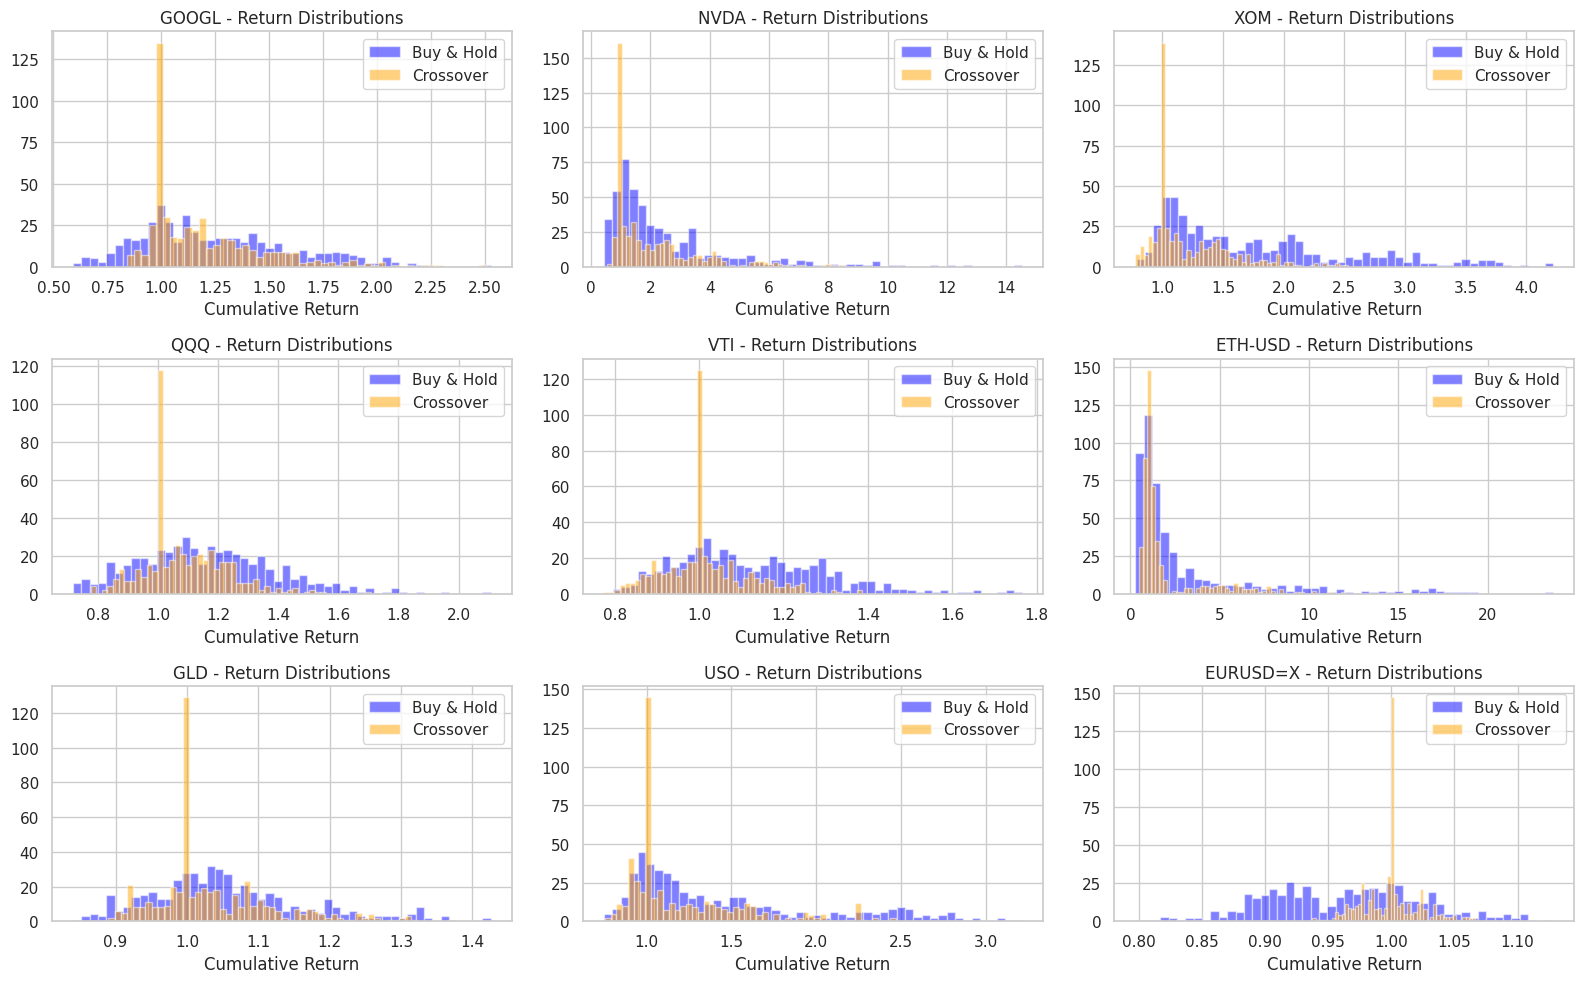

In [16]:
#plotting the distributions of returns for all the tickers selected at the beginning
sns.set(style="whitegrid")

num_keys = len(results_dict)
rows = int(np.ceil(num_keys ** 0.5))
cols = int(np.ceil(num_keys / rows))
fig, axes = plt.subplots(rows, cols, figsize=(16, 10))
axes = axes.flatten()
#loop over each key and plot distributions
for i, (key, results) in enumerate(results_dict.items()):
    df_results = pd.DataFrame(results, columns=['Buy & Hold', 'Crossover Strategy','Start', 'End', 'Entry Price', 'Exit Price', 'Operativity'])
    ax = axes[i]
    ax.hist(df_results['Buy & Hold'], bins=50, alpha=0.5, label='Buy & Hold', color='blue')
    ax.hist(df_results['Crossover Strategy'], bins=50, alpha=0.5, label='Crossover', color='orange')
    ax.set_title(f'{key} - Return Distributions')
    ax.legend()
    ax.set_xlabel('Cumulative Return')
plt.tight_layout()
plt.show()

## Bidirectional (Long & Short) Strategy

In [28]:
results_bid_dict = {}  #store results for each DataFrame

#change this number to run more simulations, up to 1000 simultations runs in short time (max 1-2 mins)
num_simulations = 500
shortMA = 20
longMA = 50

#iterate over each DataFrame in the 'data' dictionary
for key, df in data.items():
    results = []
    valid_indices = df.index[longMA:-longMA]
    #run the simulation for the current DataFrame
    for _ in range(num_simulations):
        random_start, random_end = sorted(random.sample(list(valid_indices), 2))
        df_slice = df.loc[random_start:random_end].copy()
        df_slice['shortMA'] = df_slice['Close'].rolling(window=shortMA).mean()
        df_slice['longMA'] = df_slice['Close'].rolling(window=longMA).mean()
        df_slice['position'] = 0
        df_slice.loc[df_slice['shortMA'] > df_slice['longMA'], 'position'] = 1 #LONG
        df_slice.loc[df_slice['shortMA'] < df_slice['longMA'], 'position'] = -1  #SHORT
        df_slice['position_change'] = df_slice['position'].diff().ne(0).astype(int)
        num_operations = df_slice['position_change'].sum()
        df_slice['daily_return'] = df_slice['Close'].pct_change()
        df_slice['strategy_return'] = df_slice['daily_return'] * df_slice['position']
        df_slice['cumulative_buy_hold'] = (1 + df_slice['daily_return']).cumprod()
        df_slice['cumulative_strategy'] = (1 + df_slice['strategy_return']).cumprod()
        final_bh = df_slice['cumulative_buy_hold'].iloc[-1]
        final_strat = df_slice['cumulative_strategy'].iloc[-1]
        entry_price = df_slice['Close'].iloc[0]
        exit_price = df_slice['Close'].iloc[-1]
        results.append((final_bh, final_strat, random_start, random_end, entry_price, exit_price, num_operations))

#store the results for the current DataFrame in the 'results_dict'
    results_bid_dict[key] = results


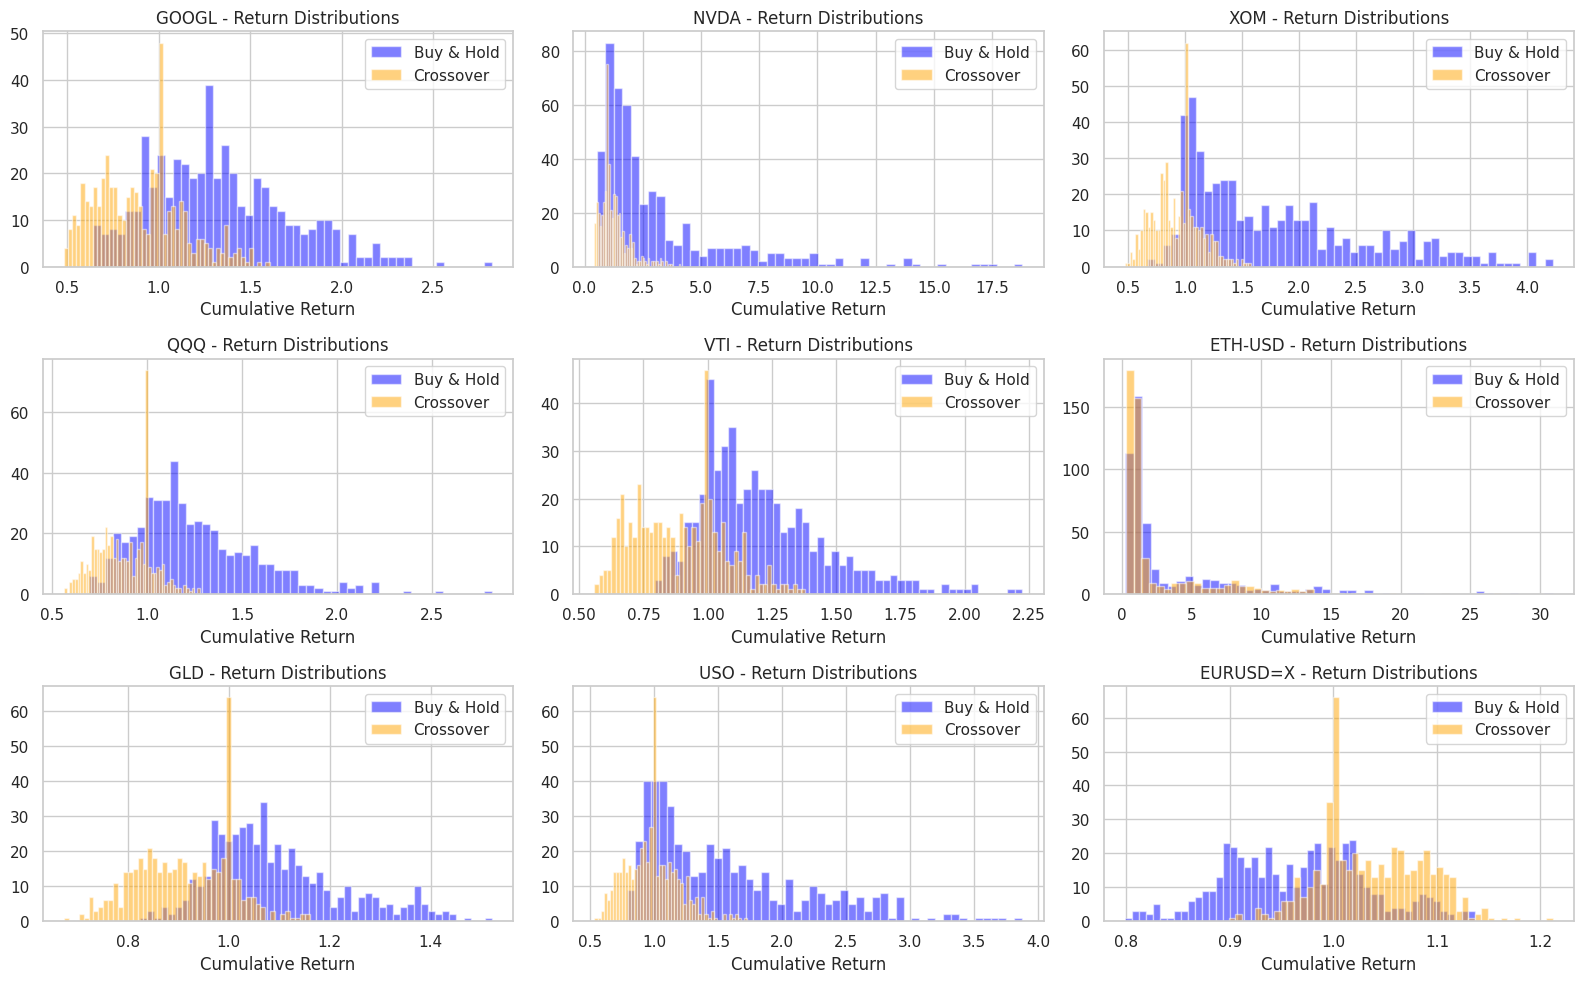

In [47]:
#plotting the distributions of returns for all the tickers selected at the beginning
sns.set(style="whitegrid")

num_keys = len(results_dict)
rows = int(np.ceil(num_keys ** 0.5))
cols = int(np.ceil(num_keys / rows))
fig, axes = plt.subplots(rows, cols, figsize=(16, 10))
axes = axes.flatten()
#loop over each key and plot distributions
for i, (key, results) in enumerate(results_bid_dict.items()):
    df_results = pd.DataFrame(results, columns=['Buy & Hold', 'Crossover Strategy','Start', 'End', 'Entry Price', 'Exit Price', 'Operativity'])
    ax = axes[i]
    ax.hist(df_results['Buy & Hold'], bins=50, alpha=0.5, label='Buy & Hold', color='blue')
    ax.hist(df_results['Crossover Strategy'], bins=50, alpha=0.5, label='Crossover', color='orange')
    ax.set_title(f'{key} - Return Distributions')
    ax.legend()
    ax.set_xlabel('Cumulative Return')
plt.tight_layout()
plt.show()

## Long only and Bidirctional Strategy: A Comparison

In [29]:
#trasforming the data insto dictionsaries of dataframes
results_df = {k: pd.DataFrame(v, columns=['Buy & Hold', 'Strategy', 'Start', 'End', 'Entry Price', 'Exit Price', 'Num Operations']) for k, v in results_dict.items()}
results_bid_df = {k: pd.DataFrame(v, columns=['Buy & Hold', 'Strategy', 'Start', 'End', 'Entry Price', 'Exit Price', 'Num Operations']) for k, v in results_bid_dict.items()}


In [31]:
results_df['GOOGL'].head()

,Buy & Hold,Strategy,Start,End,Entry Price,Exit Price,Num Operations
0,0.982294,0.971652,2021-08-05,2022-03-17,Ticker GOOGL 135.60318 Name: 2021-08-05 00:...,Ticker GOOGL 133.202179 Name: 2022-03-17 00...,5
1,0.996418,1.000000,2023-01-13,2023-02-21,Ticker GOOGL 91.681679 Name: 2023-01-13 00:...,Ticker GOOGL 91.353249 Name: 2023-02-21 00:...,1
2,1.912909,1.599938,2020-06-30,2021-08-03,Ticker GOOGL 70.565132 Name: 2020-06-30 00:...,Ticker GOOGL 134.98465 Name: 2021-08-03 00:...,6
3,1.027835,0.803183,2021-12-28,2024-03-22,Ticker GOOGL 145.989029 Name: 2021-12-28 00...,Ticker GOOGL 150.052612 Name: 2024-03-22 00...,17
4,1.245211,1.166883,2021-02-17,2022-03-04,Ticker GOOGL 105.426956 Name: 2021-02-17 00...,Ticker GOOGL 131.278839 Name: 2022-03-04 00...,7


In [35]:
summary_stats = []

for k in results_df.keys():
    long = results_df[k]
    bid = results_bid_df[k]

    mean_long = long['Strategy'].mean()
    std_long = long['Strategy'].std()
    sharpe_long = mean_long/std_long
    ops_long = long['Num Operations'].mean()

    mean_bid = bid['Strategy'].mean()
    std_bid = bid['Strategy'].std()
    sharpe_bid = mean_bid/std_bid
    sharpe_bid = bid['Strategy'].mean() / bid['Strategy'].std()
    ops_bid = bid['Num Operations'].mean()

    summary_stats.append({
        'Ticker': k,
        'Mean Long': mean_long,
        'Sdev Long': std_long,
        'Sharpe Long': sharpe_long,
        'Ops Long': ops_long,
        'Mean Bid': mean_bid,
        'Sdev Bid': std_bid,
        'Sharpe Bid': sharpe_bid,
        'Ops Bid': ops_bid,
    })

summary_df = pd.DataFrame(summary_stats)
summary_df.set_index('Ticker', inplace=True)
summary_df.round(3)


,Mean Long,Sdev Long,Sharpe Long,Ops Long,Mean Bid,Sdev Bid,Sharpe Bid,Ops Bid
Ticker,,,,,,,,
GOOGL,1.026,0.193,5.331,10.392,0.897,0.239,3.759,11.378
NVDA,1.706,1.018,1.675,8.120,1.257,0.611,2.058,9.160
XOM,1.202,0.271,4.426,8.786,0.923,0.207,4.450,9.376
QQQ,1.010,0.126,8.005,8.058,0.879,0.145,6.054,8.650
VTI,0.984,0.120,8.178,8.546,0.892,0.174,5.132,9.186
ETH-USD,2.645,3.323,0.796,12.418,2.676,3.698,0.724,12.988
GLD,0.990,0.052,19.012,8.548,0.914,0.093,9.828,9.720
USO,1.218,0.313,3.895,7.756,0.987,0.209,4.709,9.148
EURUSD=X,0.997,0.028,36.088,9.988,1.036,0.051,20.428,11.700


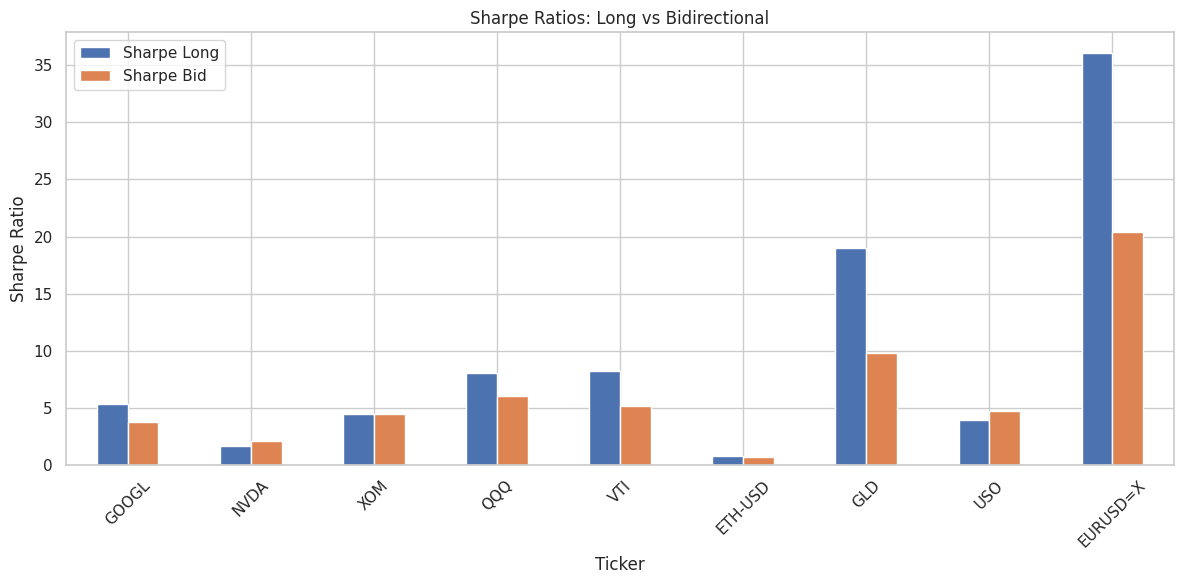

In [38]:
summary_df[['Sharpe Long', 'Sharpe Bid']].plot(kind='bar', figsize=(12, 6), title="Sharpe Ratios: Long vs Bidirectional")
plt.ylabel("Sharpe Ratio")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


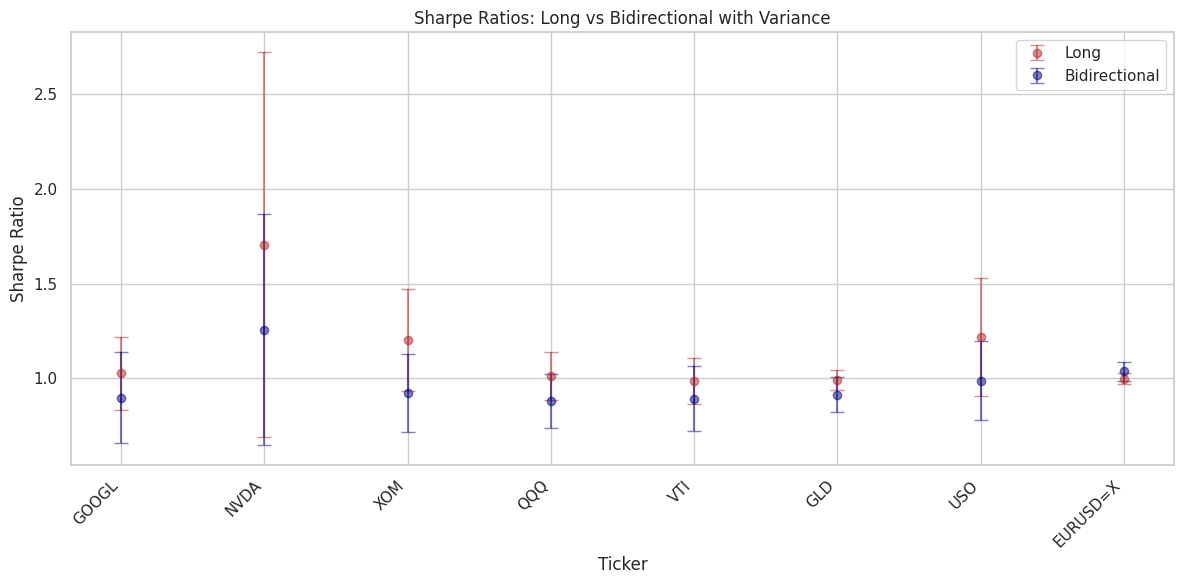

In [46]:
#I drop ETH-USD as is much more volatile and the plot is not clear for the other tickers
summary_df.drop('ETH-USD', inplace=True)
#ticker names for the x-axis
tickers = summary_df.index
#plotting
fig, ax = plt.subplots(figsize=(12, 6))
#data with error bars
ax.errorbar(tickers, summary_df['Mean Long'], yerr=summary_df['Sdev Long'], fmt='o', label='Long', capsize=5, alpha=0.5, color = 'firebrick')
ax.errorbar(tickers, summary_df['Mean Bid'], yerr=summary_df['Sdev Bid'], fmt='o', label='Bidirectional', capsize=5, alpha=0.5, color='navy')
ax.set_title("Sharpe Ratios: Long vs Bidirectional with Variance")
ax.set_xlabel("Ticker")
ax.set_ylabel("Sharpe Ratio")
ax.legend()
ax.grid(True)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Final Comments
Overall we can observe that:
1. Ina 5 year period where the market is mostly uptrend, A buy and hold strategy performs better than a strategy purely based on crossing moving averages. This delta of returns is greater the less the equity is volatile.
2. When taking into account more volatile equities, the long only strategy performs quite well (see NVDIA, ETH) and also perfroms quite well in the case of EURUSD. In accordance to what we said before, the only case in which the MA strategy performs much better is on EURUSD which presents a brearish market structure in the last 5 years.
3. When using a bidirectional strategy, the gap increases as going short against a bullish market it is not considered a good strategy. Specially when we focus only on MAs which are affected by lags.
4. Comparing long only and bidirectional strategy confirms that the in an uptrend market the long only performs better. If we also take into account teh transaction cost the conditions is even worse. In this simulation I did not accounted for this cost but the number of operations (ops) is a proxy for this extra cost of frequent operation.

More complex strategies will be tested in the following case studies :)